For each pixel calculate the histogram of the neighbourhood and assign the most probable candidate's value 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided

import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
import json

import image_processing_utils as ipu

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def imshow(image: np.ndarray):
    im_out = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(im_out)

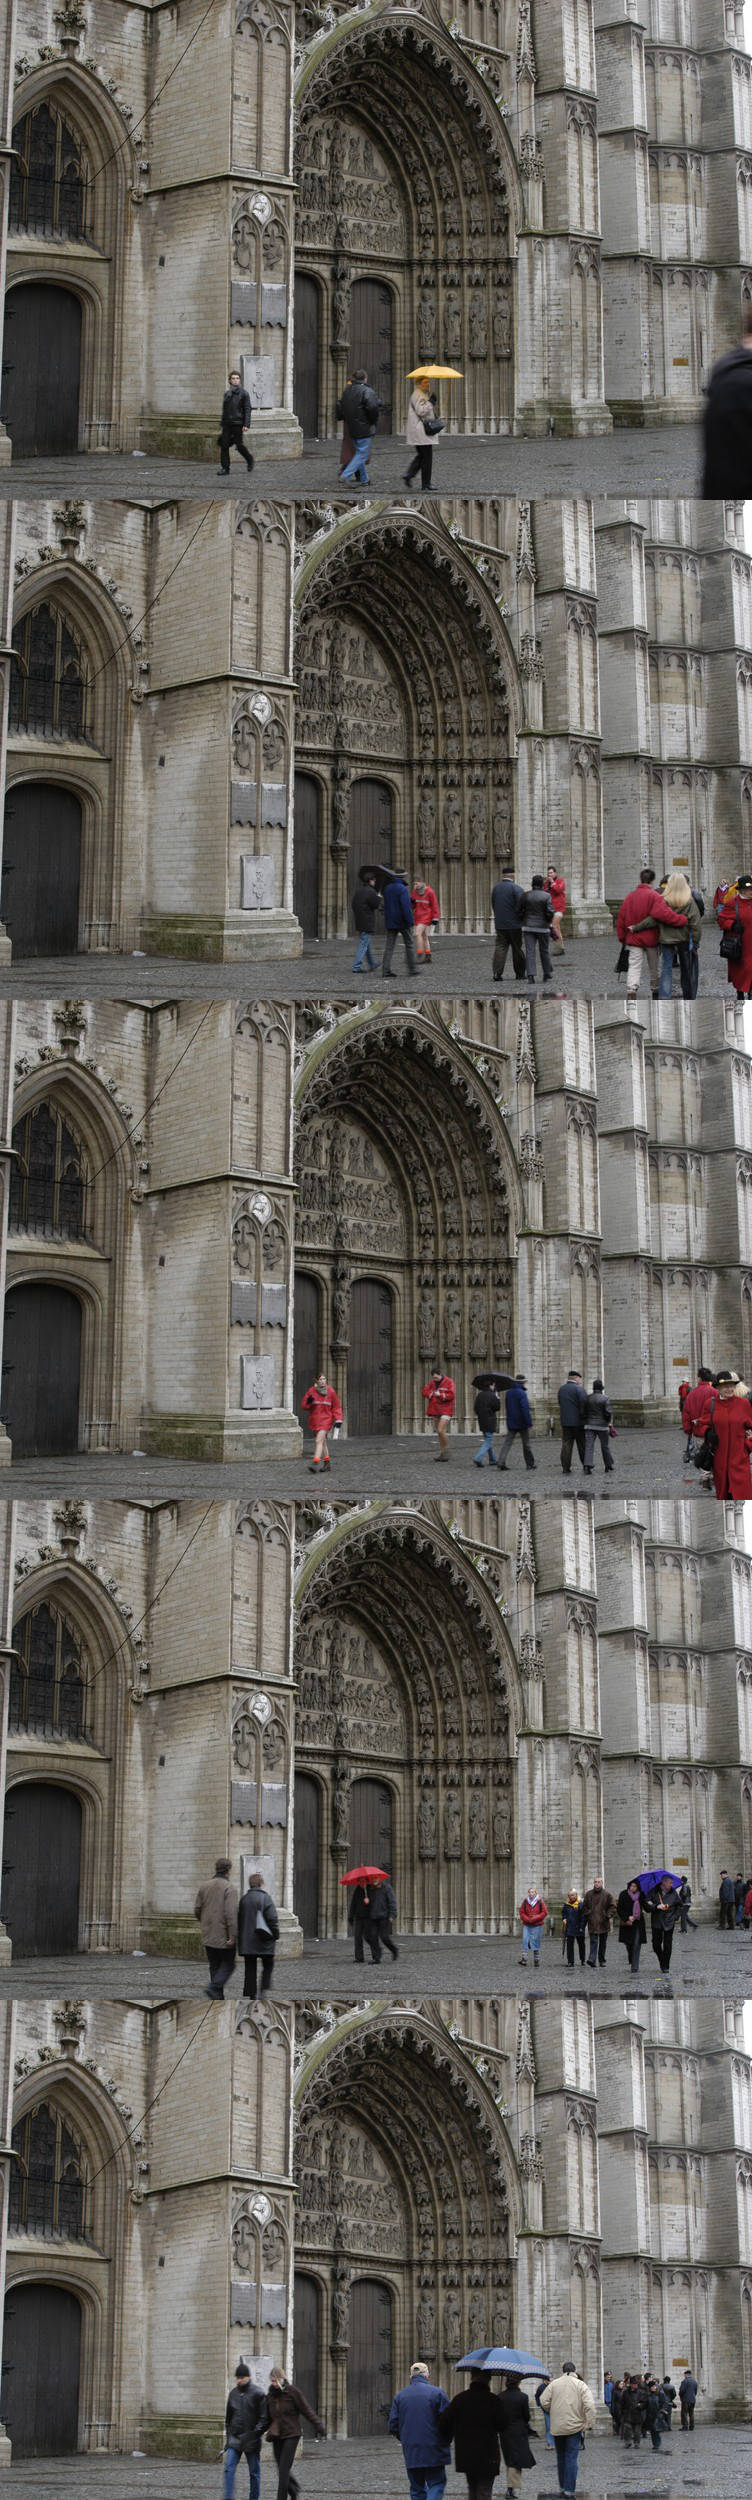

In [3]:
files = 'd001.jpg d002.jpg d003.jpg d004.jpg d005.jpg result.png'.split(' ')
files_paths = [os.path.join('..','data','cathedral', x) for x in files]

images = [cv2.imread(x, 1) for x in files_paths]
images, target = images[:-1], images[-1]

imshow(np.concatenate(images[:5],0) )

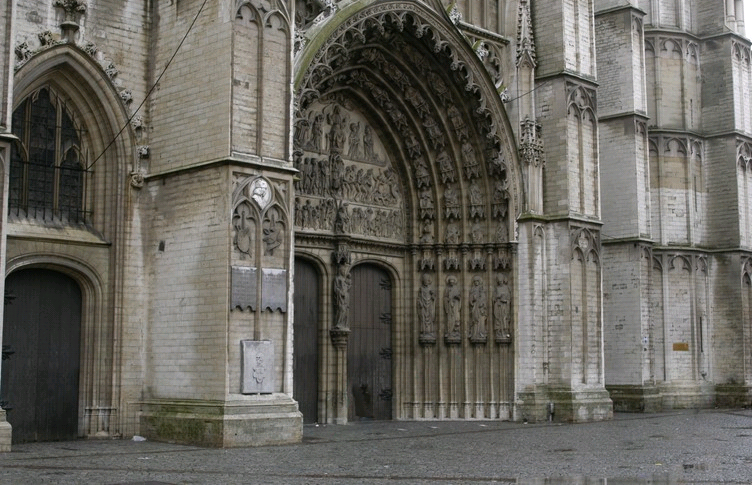

In [4]:
imshow(target)

In [5]:
def get_clean_background(images, bins=256):
    
    bin_span = int(256/bins)
    histogram = ipu.get_histogram(images, bins=bins)

    images_stacked = np.stack(images, axis=-2)

    labeling = np.zeros(shape=images_stacked.shape[:2], dtype=np.int8) # for each pixel store the assigned original photo

    shape = images_stacked.shape
    probabilities = np.zeros(shape=shape[:-1])
    im_out = np.zeros(shape=(shape[0], shape[1], 3))
    
    for row in range(shape[0]):
        for column in range(shape[1]):
            for sample in range(shape[2]):
                
                # probability of three independent events ()
                probabilities[row,column,sample] = histogram[0, images_stacked[row,column,sample, 0]//bin_span] * histogram[1, images_stacked[row,column,sample, 1]//bin_span] * histogram[2, images_stacked[row,column,sample, 2]//bin_span]
            # chose the sample with the highest probability
            labeling[row,column] = np.argmax(probabilities[row, column]).astype(int)
            


            im_out[row,column] = images_stacked[row,column, labeling[row,column]]

    return im_out.astype('uint8')



In [13]:
clean_img = get_clean_background(images_cropped, bins=8)

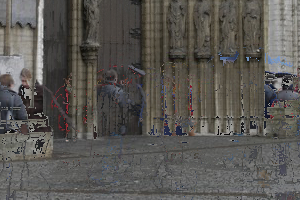

In [14]:


imshow(clean_img.astype('uint8'))

histograms computed on neighbourhoods

I will divide the photo into 

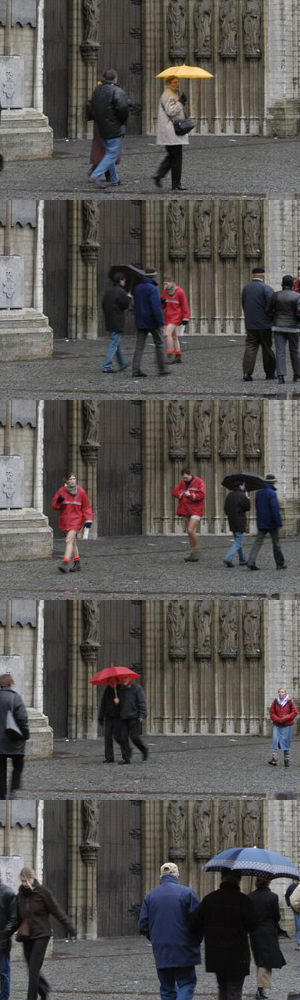

In [9]:
# i wil work on smaller images
images_cropped = [img[300:, 250: 550] for img in images]

imshow(np.concatenate(images_cropped,0))

This method will use calculating histograms over neighbourhoods

In [10]:
def get_images_with_each_pixels_neighbourhood(images: list, n_size):
    # first - create an array
    images_stacked = np.stack(images, axis=-1)
    images_padded_stacked = np.stack([cv2.copyMakeBorder(image, n_size, n_size, n_size, n_size, borderType=cv2.BORDER_REFLECT) for image in images],axis=-1).astype('uint8')

    s = images_padded_stacked.shape
    print(s)
    new_strides = images_padded_stacked.strides[:2] + images_padded_stacked.strides[:2] + (s[-1], 1)
    print(new_strides)
    images_neighbourhoods = as_strided(
        images_padded_stacked, 
        strides=new_strides,
        shape=(s[0]-2*n_size, s[1]-2*n_size, 2*n_size+1, 2*n_size+1, 3, s[-1])
    )

    return images_neighbourhoods

In [11]:
images_with_neighbourhoods = get_images_with_each_pixels_neighbourhood(images_cropped, 5)

(210, 310, 3, 5)
(4650, 15, 4650, 15, 5, 1)


In [12]:
images_with_neighbourhoods.shape

(200, 300, 11, 11, 3, 5)

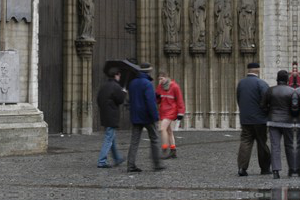

In [13]:
imshow(images_with_neighbourhoods[:,:,10,10,:,1])

In [14]:
def get_histograms_of_each_pixel_neighbourhood(images: list, n_size, bins=8):
    bin_span = int(256/bins)
    img_w_n = get_images_with_each_pixels_neighbourhood(images, n_size)
    shape = img_w_n.shape
    # the output should be the histogram for each pixel
    # for each pixel coordinte there will be a histogram
    histogram_matrix = np.zeros((shape[0], shape[1]))

    labeling = np.zeros(shape=shape[:2], dtype=np.int8)
    im_out = np.zeros(shape=(shape[0], shape[1], 3))

    img_reshaped = np.transpose(img_w_n, (0,1,2,3,5,4))
    for row in range(shape[0]):
        for col in range(shape[1]):
            #histogram_matrix[row,col] = ipu.get_histogram(img_w_n[row, col])
            histogram = ipu.get_histogram(img_w_n[row,col], bins)
            probabilities = []
            for sample in img_reshaped[row,col,n_size, n_size]: # 2d array (sample, color)
                probabilities.append(histogram[0, sample[0]//bin_span] * histogram[1, sample[1]//bin_span]* histogram[2, sample[2]//bin_span])

            labeling[row,col] = np.argmax(probabilities).astype(int)
            im_out[row,col] = img_reshaped[row,col, n_size, n_size, labeling[row,col]]

    return im_out.astype('uint8')



In [15]:
img_clean = get_histograms_of_each_pixel_neighbourhood(images_cropped, 40)

(280, 380, 3, 5)
(5700, 15, 5700, 15, 5, 1)


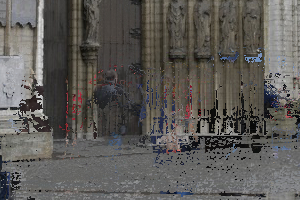

In [10]:
imshow(img_wonderfull)